In [1]:
import sys
import os
import json
sys.path.append("..")

import torch
from torch.optim.lr_scheduler import LambdaLR, StepLR
import torch.optim as optim
import random 
import numpy as np

from tasks.burgers_1d import Burgers1D
from models.pinn import PINN
from models.sapinn import SA_PINN
from models.dbpinn import DB_PINN
from models.utils.schedulers import LambdaScheduler
from common.train_functions import *
from common.plotting import *

In [2]:
print("CUDA Version:", torch.version.cuda)
print(torch.backends.cudnn.enabled)  # Should be True
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.get_device_name(0))

CUDA Version: 12.8
True
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [3]:
def save_eval_losses(eval_losses, filename):
    with open(filename, 'w') as f:
        json.dump(eval_losses, f)

def save_u_results(T, X, U, filename):
    with open(filename, 'w') as f:
        json.dump({
            "t_map": T.tolist(), "x_map": X.tolist(), "u_map": U.tolist()
        }, f)

def save_model(model, filename):
    """Save the model's state dictionary to a file."""
    torch.save(model.cpu().state_dict(), filename)

In [4]:
# Fix random number generators
seed = 42
torch.manual_seed(seed)  # For PyTorch
random.seed(seed)        # For random
np.random.seed(seed)     # For NumPy

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
viscosity = 0.01 / np.pi  # Viscosity
burgers_1d = Burgers1D(nu=viscosity)

In [7]:
# Set number of data points
N_0 = 50
N_b = 50
N_d = 0
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

In [8]:
# Set boundaries
lb = torch.tensor([tmin, xmin], dtype=torch.float32, requires_grad=False)  # Lower bounds
ub = torch.tensor([tmax, xmax], dtype=torch.float32, requires_grad=False)  # Upper bounds

# Generate points for initial conditions
t_0 = torch.ones((N_0, 1), dtype=torch.float32, requires_grad=True) * lb[0]
x_0 = torch.rand((N_0, 1), dtype=torch.float32, requires_grad=True) * (ub[1] - lb[1]) + lb[1]
X_0 = torch.cat([t_0, x_0], dim=1)

# Compute initial condition at points x_0
u_0 = burgers_1d.initial_conditions(x_0)

# Generate points for boundary conditions
t_b = torch.rand((N_b, 1), dtype=torch.float32, requires_grad=True) * (ub[0] - lb[0]) + lb[0]
x_b = lb[1] + (ub[1] - lb[1]) * torch.bernoulli(torch.full((N_b, 1), 0.5, dtype=torch.float32))
x_b.requires_grad_(True)  # Set requires_grad=True for x_b
X_b = torch.cat([t_b, x_b], dim=1)

# Compute boundary condition at points (t_b, x_b)
u_b = burgers_1d.boundary_conditions(t_b)

# Generate points for collocation
t_r = torch.rand((N_r, 1), dtype=torch.float32, requires_grad=True) * (ub[0] - lb[0]) + lb[0]
x_r = torch.rand((N_r, 1), dtype=torch.float32, requires_grad=True) * (ub[1] - lb[1]) + lb[1]
X_r = torch.cat([t_r, x_r], dim=1)

## Plot generated points

Text(0.5, 1.0, 'Positions of collocation points and boundary data')

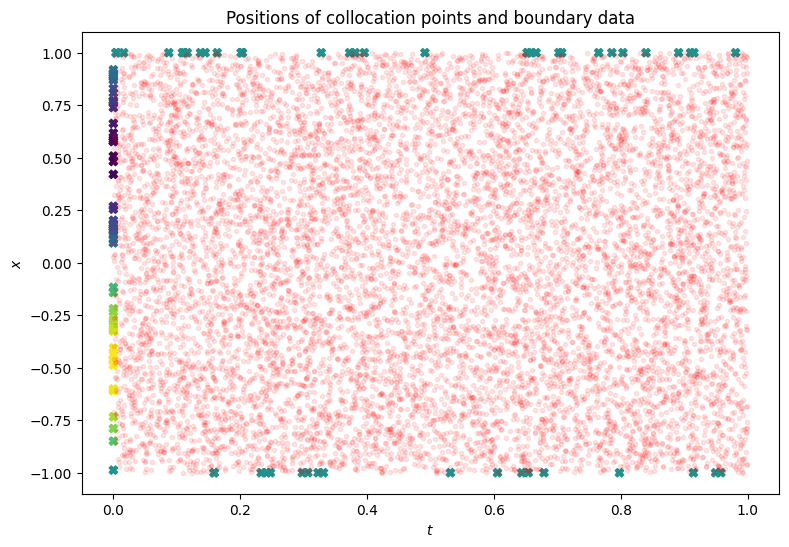

In [9]:
fig = plt.figure(figsize=(9, 6))
plt.scatter(t_0.detach().numpy(), x_0.detach().numpy(), c=u_0.detach().numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_b.detach().numpy(), x_b.detach().numpy(), c=u_b.detach().numpy(), marker='X', vmin=-1, vmax=1)
plt.scatter(t_r.detach().numpy(), x_r.detach().numpy(), c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data')
# plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

# PINN

In [10]:
# Set training parameters
max_epoch = 10000
base_pinn = PINN(
    input_dim=2,
    output_dim=1,
    hidden_layers= 9 * [20], 
    equation=burgers_1d
).to("cpu")
optimizers = {
    "model": optim.Adam(base_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [11]:
train_loss, eval_losses = train_pinn(
    max_epoch, 
    base_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device="cpu"
)

Epoch: 50/10000, PINN Loss: 0.39997, True Loss: 0.39939


KeyboardInterrupt: 

In [ ]:
# Set up meshgrid
base_pinn.to("cpu")
torch.cuda.empty_cache()
N = 501
T, X, U = compute_approximation_2d(base_pinn, lb, ub, N)

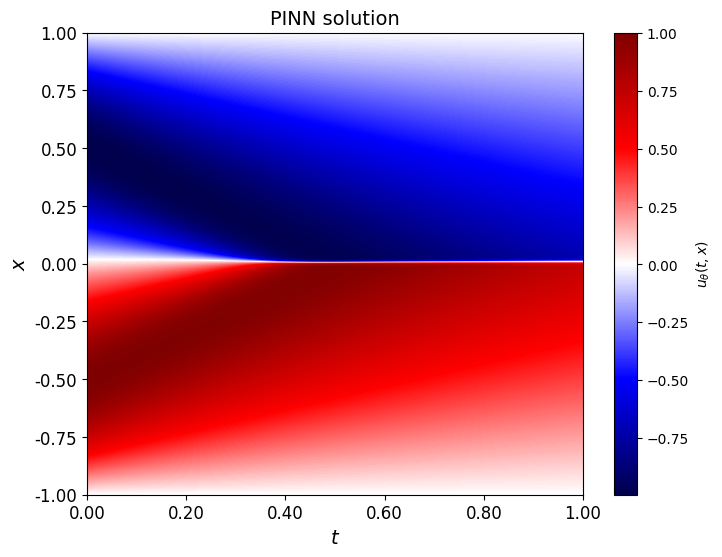

In [ ]:
plot_single_heatmap_2d(T, X, U, title="PINN solution")

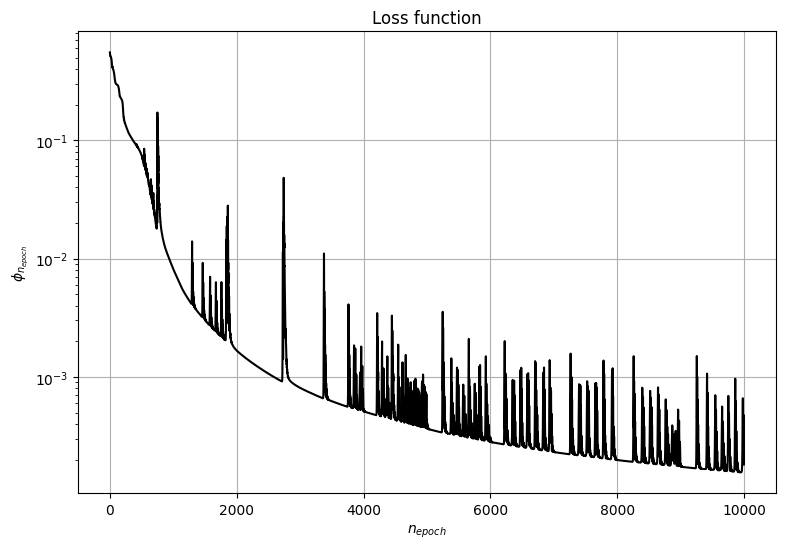

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(eval_losses)), eval_losses,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')
ax.set_title('Loss function')
plt.grid()
# plt.savefig('../pics/1d_burgers/loss/burgers_v5.png', bbox_inches='tight', dpi=300);

In [ ]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "pinn.json"))
save_eval_losses(eval_losses, os.path.join("..", "data", "loss", "pinn.json") )
save_model(base_pinn, os.path.join("..", "saved_models", "1d_burgers", "pinn.pt"))

# RFF-PINN

In [ ]:
# Set training parameters
max_epoch = 10000
rff_pinn = PINN(
    input_dim=2,
    rff_features=20,
    output_dim=1,
    hidden_layers= 9 * [42],
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(rff_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [ ]:
rff_pinn.to(device)
train_loss, eval_losses = train_pinn(
    max_epoch, 
    rff_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device
)

C:\Users\ritka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 50/10000, PINN Loss: 0.183957040309906, True Loss: 0.17645734548568726
Epoch: 100/10000, PINN Loss: 0.15905484557151794, True Loss: 0.15899570286273956
Epoch: 150/10000, PINN Loss: 0.15729618072509766, True Loss: 0.15725389122962952
Epoch: 200/10000, PINN Loss: 0.15499183535575867, True Loss: 0.15514248609542847
Epoch: 250/10000, PINN Loss: 0.13364991545677185, True Loss: 0.13323882222175598
Epoch: 300/10000, PINN Loss: 0.11531456559896469, True Loss: 0.11489210277795792
Epoch: 350/10000, PINN Loss: 0.0765279233455658, True Loss: 0.07543332874774933
Epoch: 400/10000, PINN Loss: 0.046412914991378784, True Loss: 0.05545533448457718
Epoch: 450/10000, PINN Loss: 0.02981651946902275, True Loss: 0.03241904079914093
Epoch: 500/10000, PINN Loss: 0.024427486583590508, True Loss: 0.02696077898144722
Epoch: 550/10000, PINN Loss: 0.013408156111836433, True Loss: 0.013510753400623798
Epoch: 600/10000, PINN Loss: 0.009980708360671997, True Loss: 0.010145376436412334
Epoch: 650/10000, PINN Los

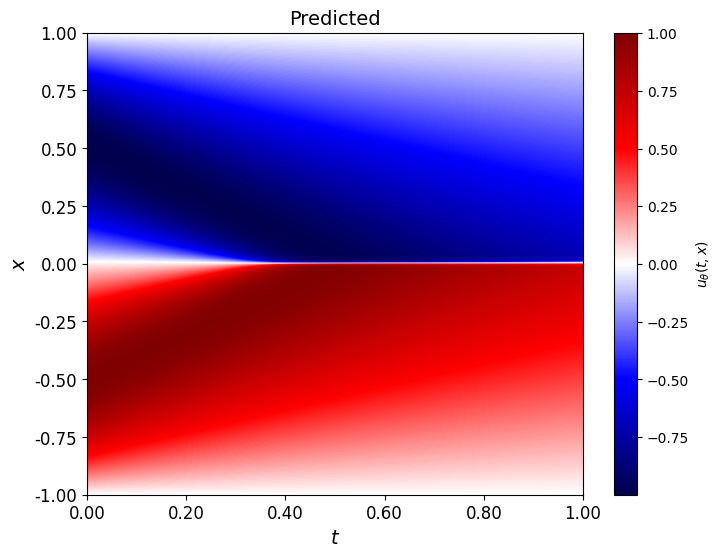

In [ ]:
rff_pinn.to("cpu")
T, X, U = compute_approximation_2d(rff_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

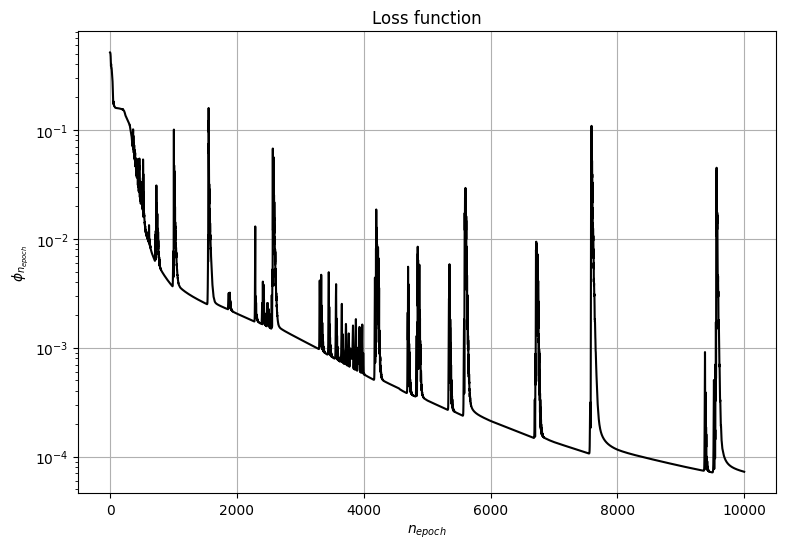

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(eval_losses)), eval_losses,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')
ax.set_title('Loss function')
plt.grid()
# plt.savefig('../pics/1d_burgers/loss/burgers_v5.png', bbox_inches='tight', dpi=300);

In [ ]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "rff_pinn.json"))
save_eval_losses(eval_losses, os.path.join("..", "data", "loss", "rff_pinn.json"))
save_model(rff_pinn, os.path.join("..", "saved_models", "1d_burgers", "rff_pinn.pt"))

NameError: name 'rff_pinn' is not defined

# SA-PINN + RFF

In [10]:
# Set training parameters
max_epoch = 10000
sa_pinn = SA_PINN(
    input_dim=2,
    output_dim=1,
    activation=torch.nn.Tanh(),
    hidden_layers= 9 * [42],
    equation=burgers_1d,
    points_pde=X_r,
    points_ics=X_0,
    points_bcs=X_b
).to(device)
optimizer = torch.optim.Adam(sa_pinn.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.9)
optimizers = {
    "model": optim.Adam(sa_pinn.u_model.parameters(), lr=1e-4),
    "lambdas_pde": optim.Adam([sa_pinn.lambdas_pde], lr=1e-2),
    "lambdas_ics": optim.Adam([sa_pinn.lambdas_ics], lr=1e-2),
    "lambdas_bcs": optim.Adam([sa_pinn.lambdas_bcs], lr=1e-2)
}
schedulers = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9),
    "lambdas_pde": LambdaScheduler(optimizers["lambdas_pde"], N_warmup=500, base_scheduler=optim.lr_scheduler.StepLR, step_size=100,gamma=0.9),
    "lambdas_ics": LambdaScheduler(optimizers["lambdas_ics"], N_warmup=500, base_scheduler=optim.lr_scheduler.StepLR, step_size=100,gamma=0.9),
    "lambdas_bcs": LambdaScheduler(optimizers["lambdas_bcs"], N_warmup=500, base_scheduler=optim.lr_scheduler.StepLR, step_size=100,gamma=0.9)
}

c:\Users\ritka\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [12]:
sa_pinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    sa_pinn, optimizers, schedulers,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device
)

Epoch: 50/10000, PINN Loss: 0.39837, True Loss: 0.39797
Epoch: 100/10000, PINN Loss: 0.35090, True Loss: 0.34914
Epoch: 150/10000, PINN Loss: 0.28023, True Loss: 0.27966
Epoch: 200/10000, PINN Loss: 0.25177, True Loss: 0.25108
Epoch: 250/10000, PINN Loss: 0.22202, True Loss: 0.22150
Epoch: 300/10000, PINN Loss: 0.17354, True Loss: 0.17274
Epoch: 350/10000, PINN Loss: 0.15818, True Loss: 0.15803
Epoch: 400/10000, PINN Loss: 0.22333, True Loss: 0.15929
Epoch: 450/10000, PINN Loss: 0.36841, True Loss: 0.16183
Epoch: 500/10000, PINN Loss: 0.52625, True Loss: 0.14908
Epoch: 550/10000, PINN Loss: 0.68034, True Loss: 0.13420
Epoch: 600/10000, PINN Loss: 0.86706, True Loss: 0.11864
Epoch: 650/10000, PINN Loss: 1.07633, True Loss: 0.11047
Epoch: 700/10000, PINN Loss: 1.22341, True Loss: 0.10193
Epoch: 750/10000, PINN Loss: 1.31327, True Loss: 0.08919
Epoch: 800/10000, PINN Loss: 1.37953, True Loss: 0.07757
Epoch: 850/10000, PINN Loss: 1.46054, True Loss: 0.06948
Epoch: 900/10000, PINN Loss: 1.5

KeyboardInterrupt: 

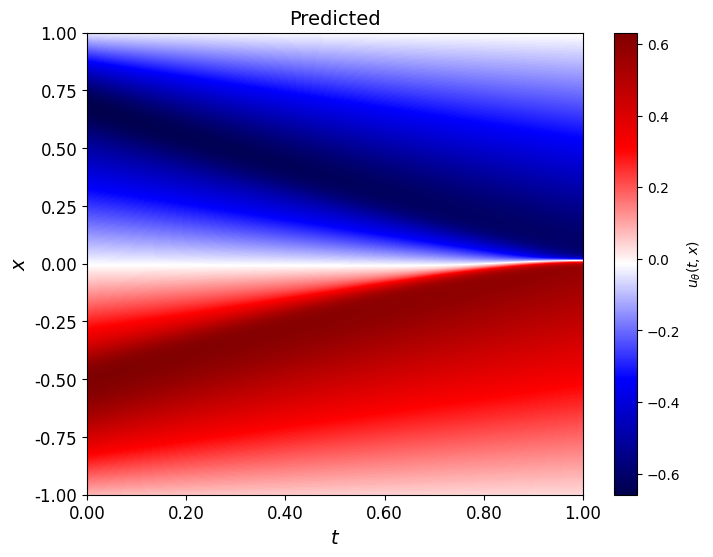

In [ ]:
sa_pinn.to("cpu")
T, X, U = compute_approximation_2d(sa_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

In [ ]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "sa_rff_pinn.json"))
save_eval_losses(eval_losses, os.path.join("..", "data", "loss", "sa_rff_pinn.json") )
save_model(rff_pinn, os.path.join("..", "saved_models", "1d_burgers", "sa_rff_pinn.pt"))

# DB-PINN + RFF

In [10]:
# Set training parameters
max_epoch = 10000
db_pinn = DB_PINN(
    input_dim=2,
    rff_features=20,
    output_dim=1,
    hidden_layers= 9 * [42],
    equation=burgers_1d
).to(device)
optimizers = {
    "model": optim.Adam(db_pinn.parameters(), lr=1e-3),
}
scheduler = {
    "model": optim.lr_scheduler.StepLR(optimizers["model"], step_size=1000, gamma=0.9)
}

In [11]:
db_pinn.to("cuda")
train_loss, eval_loss = train_pinn(
    max_epoch, 
    db_pinn, optimizers, scheduler,
    X_r, X_0, X_b, 
    x_data = None, u_data = None, device=device
)

c:\Users\ritka\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


TypeError: expected Tensor as element 0 in argument 0, but got tuple

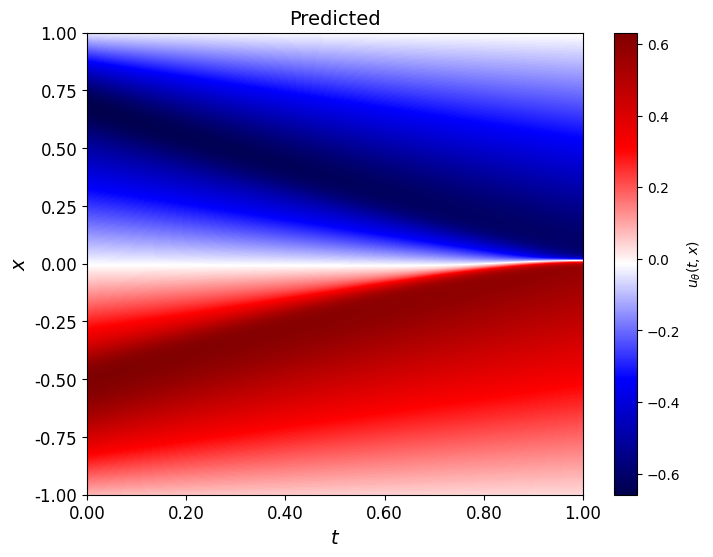

In [ ]:
sa_pinn.to("cpu")
T, X, U = compute_approximation_2d(sa_pinn, lb, ub, N)
plot_single_heatmap_2d(T, X, U, title="Predicted") # save_path="../pics/1d_burgers/plots/sa_pinn_v001divpi.png")

In [ ]:
save_u_results(T, X, U, os.path.join("..", "data", "results", "sa_rff_pinn.json"))
save_eval_losses(eval_losses, os.path.join("..", "data", "loss", "sa_rff_pinn.json") )
save_model(rff_pinn, os.path.join("..", "saved_models", "1d_burgers", "sa_rff_pinn.pt"))

# Analytic solution

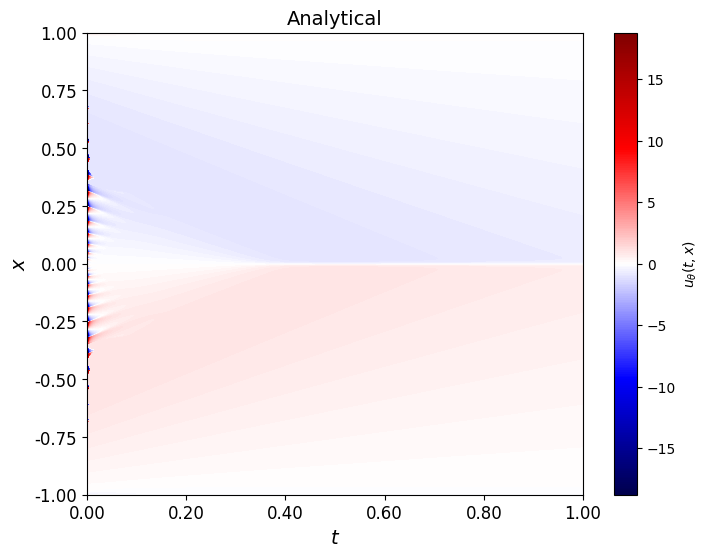

In [ ]:
correct = burgers_1d.analytical_solution(T, X)
plot_single_heatmap_2d(T, X, correct, title="Analytical") 

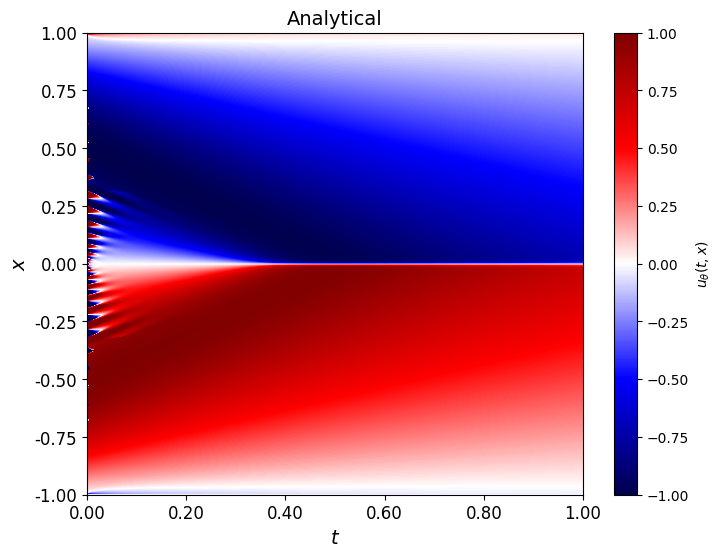

In [ ]:
plot_single_heatmap_2d(
    T, X, correct.clip(min=-1, max=1, out=correct), 
    title="Analytical"
) 

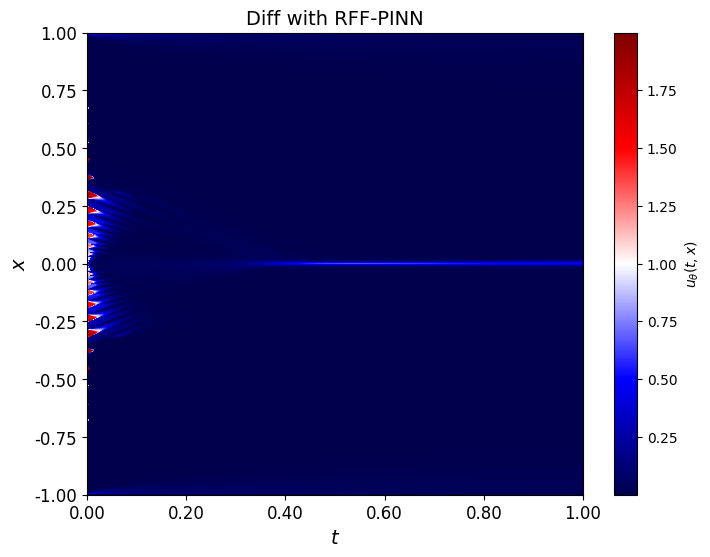

In [ ]:
with open(os.path.join("..", "data", "results", "rff_pinn.json")) as f:
    data = json.load(f)
plot_single_heatmap_2d(
    T, X, np.abs(data["u_map"] - correct.clip(min=-1, max=1, out=correct)), 
    title="Diff with RFF-PINN"
) 